
# Telco Customer Churn Analysis

## 1. Problem Definition
   
This project aims to predict whether a customer will churn and compare multiple models to select the best one based on performance and interpretability. The dataset that will be used is Telco Customer Churn from Kaggle.(https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download).
Each row corresponds to an individual customer, with columns representing customer attributes as defined in the metadata. The dataset contains information on:
- **Churn status**, indicating whether a customer left the service in the previous month
- **Subscribed services**, including phone service, multiple lines, internet, online security, online backup, device protection, technical support, and streaming services
- **Account details**, such as customer tenure, contract type, payment method, paperless billing status, monthly charges, and total charges
- **Demographic characteristics**, including gender, age group, and whether the customer has a partner or dependents

The response variable here is **Churn** column with all other variables being the covariates.

## 2. Data Loading & Cleaning

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [20]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

df = df.drop(columns=["customerID"])

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna()

In [4]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


## 3. Exploratory Data Analysis

In [5]:
df["Churn"].value_counts(normalize=True)

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64

From the above proportion, we see that most customers are retained, but roughly 1 in 4 customers churned, which is significant and worth analyzing for risk patterns.

/var/folders/zv/ljgjz5z10y93dzq0hqkt_5zh0000gn/T/ipykernel_2251/2346013551.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Contract", y="Churn", data=contract_churn, palette="Blues_d")


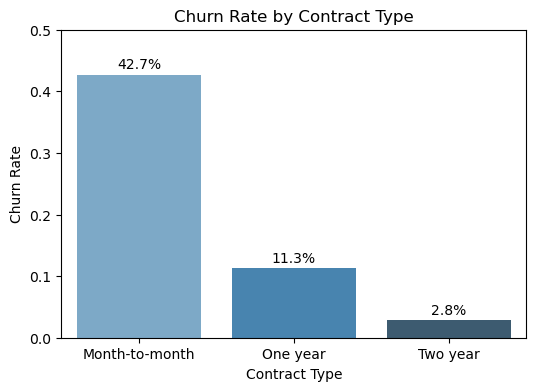

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mean churn per contract type
contract_churn = df.groupby("Contract")["Churn"].mean().reset_index()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x="Contract", y="Churn", data=contract_churn, palette="Blues_d")

# Labels and title
plt.ylabel("Churn Rate")
plt.xlabel("Contract Type")
plt.title("Churn Rate by Contract Type")
plt.ylim(0, 0.5)  # adjust if needed

# Add percentage labels on top of bars
for i, row in contract_churn.iterrows():
    plt.text(i, row.Churn + 0.01, f"{row.Churn:.1%}", ha='center', fontsize=10)

plt.show()

The plot showed that month-to-month customers are much more likely to leave (around 43% churn), one-year contracts have moderate churn (about 11%), and two-year contracts are highly sticky (only about 3% churn). We see a pattern that longer-term contracts dramatically reduce churn, and so this suggests that customer loss might be considerably decreased by strategies for retention (such as incentives to switch to longer contracts).

## 4. Preprocessing

In [7]:
# Train-Test Split
X = df.drop(columns="Churn")
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first"), cat_features)
    ]
)

## 5. Modeling

### Model 1: Logistic Regression (Baseline)

In [9]:
lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

### Model 2: LASSO Logistic Regression

In [10]:
lasso = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        penalty="l1", solver="liblinear", max_iter=1000
    ))
])

### Model 3: Random Forest

In [11]:
rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"
    ))
])

## 6. Evaluation

### Cross-Validation

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": lr,
    "LASSO Logistic": lasso,
    "Random Forest": rf
}

for name, model in models.items():
    auc = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")
    print(name, "Mean AUC:", auc.mean())

Logistic Regression Mean AUC: 0.8460801541862706
LASSO Logistic Mean AUC: 0.8459323653501988
Random Forest Mean AUC: 0.8294209107031509


### Plot ROC Curve

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

models = {
    "Logistic Regression": Pipeline([
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "LASSO Logistic": Pipeline([
        ("preprocess", preprocessor),
        ("model", LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000))
    ]),
    "Random Forest": Pipeline([
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"))
    ])
}

for name, model in models.items():
    model.fit(X_train, y_train)

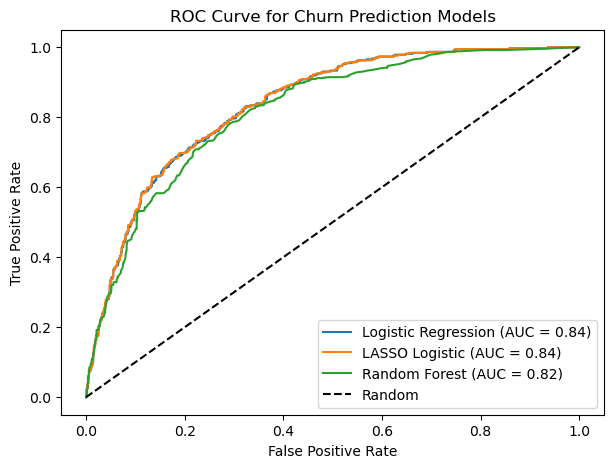

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(7,5))

for name, model in models.items():
    
    y_prob = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0,1], [0,1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Churn Prediction Models")
plt.legend()
plt.show()

Logistic Regression has the greatest mean AUC (0.846), closely followed by LASSO Logistic (0.846), according to cross-validated data. Random Forest's performance is a little lower (0.829). This implies that there are few advantages to regularisation or more complex non-linear models, and the dataset is best suited for a linear model. Due to its high predictive accuracy and interpretability, logistic regression is chosen as the final model.

### Test Set Performance

In [14]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_prob)

0.8186774929984314

On the held-out test set, the final Logistic Regression model achieves a ROC-AUC of 0.819, indicating strong predictive performance on unseen data. The small drop from the cross-validated AUC (0.846) suggests good generalization and minimal overfitting. This model can reliably identify customers at risk of churn, enabling targeted retention strategies.

## 7. Interpretation
The Logistic Regression model indicates that contract type and customer tenure are the strongest predictors of churn, with month-to-month contracts and shorter tenure substantially increasing the likelihood of customer attrition. This suggests that customers with less long-term commitment are more prone to leaving the service. The Random Forest model supports this finding, as contract type and tenure also appear among the most influential features in determining churn, highlighting consistent patterns across linear and non-linear models. Overall, the agreement between models suggests that churn behavior in this dataset is driven primarily by customer commitment length rather than complex feature interactions.

## 8. Conclusion
Logistic Regression was selected as the final model, as it achieved the highest cross-validated ROC-AUC and demonstrated strong generalization performance on the test set while remaining highly interpretable. Its coefficients provide clear insights into how factors such as contract type and tenure influence churn, making the model suitable for both prediction and decision-making. A limitation of this analysis is that the model relies on a limited set of observed features and does not capture potential temporal changes in customer behavior. With additional time, performance could be improved by incorporating time-based features or performing targeted hyperparameter tuning to further optimize model performance.